## scPrinter

scPrinter 是一个用于单细胞 ATAC-seq 数据的多尺度足迹分析的计算框架。scPrinter 旨在通过足迹分析识别和可视化驱动细胞类型特异性基因表达程序的调控元素。scPrinter 使用深度学习模型从单细胞 ATAC-seq 数据中预测转录因子的活性。scPrinter 还提供了一套可视化工具，用于探索计算出的多尺度足迹。

- 文章：Multiscale footprints reveal the organization of *cis*-regulatory elements

- 期刊：Nature

- 发表时间：2025.01.22

- 通讯作者：Jason D. Buenrostro（Broad Institute）

- 第一作者：Yan Hu（Broad Institute）

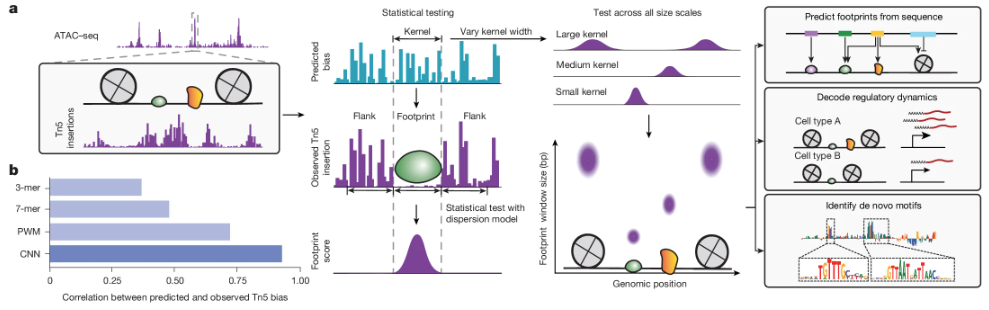

### Tn5 序列偏好性建模

#### 背景

Tn5 转座酶在 ATAC-seq 中用于标记开放染色质，但其插入受局部 DNA 序列影响，存在偏好性。为校正此偏好性，研究者开发了一个卷积神经网络（CNN）模型，预测单碱基分辨率的 Tn5 插入偏好性。

#### 方法

- 数据获取：
	- Tn5 插入片段末端调整（+4/-4 bp），统计 cCRE 内单碱基插入次数，存储为三维张量（样本 × cCRE × 位置）。

- 数据预处理：
	- 输入：±50 bp 序列，one-hot 编码为 101 × 4 矩阵。
	- 目标：局部相对 Tn5 偏好性（插入计数 / ±50 bp 均值），log10 变换并缩放。
	- 数据集：80% 训练、10% 验证、10% 测试，均衡样本并用反向互补序列增强。

#### 模型架构

- 结构：
	- 3 个卷积 + 最大池化层：32 个 5 bp 滤波器，ReLU 激活。
	- 2 个全连接层：32 维 (ReLU) → 1 维 (线性输出)。
- 任务： 回归预测 Tn5 偏好性。

#### 训练与评估

- 训练： Keras 实现，MSE 损失，Adam 优化器，批次大小 64，验证集早停。
- 评估： 测试集验证性能，与 k-mer、PWM 和 ChromBPNet 模型比较。

#### 应用

- 生成多种物种（人类 hg38、小鼠 mm10 等）的全基因组 Tn5 偏好性参考轨道，供 ATAC-seq 分析使用。

### Footprint 得分计算

#### 背景

为检测 cCRE 内不同尺度的 DNA-蛋白质相互作用，设计了一个框架，计算每个碱基位置的 footprint 得分。Footprint 得分反映蛋白质结合的可能性，通过比较 Tn5 插入的中心与侧翼区域比例，并结合背景分布进行统计评估。

#### 方法

- Footprint 定义：
	- 每个位置定义中心窗口及其两侧侧翼窗口，计算 Tn5 插入的中心/(中心 + 侧翼) 比例。
- 背景分布估计：
	- 从 BAC 裸 DNA 数据随机采样 10 万个位置，提取局部覆盖度、中心偏好性和侧翼偏好性。
	- 对每个位置，基于三维空间（归一化后）找到 500 个最近邻，构建背景比例分布，计算均值和标准差。
	- 下采样 BAC 数据（50%、20%、10%、5%、1% 测序深度）以覆盖多样局部覆盖度。

#### 模型架构

- 结构：
	- 单隐藏层神经网络：32 节点，ReLU 激活；输出层线性激活。
- 任务： 回归预测背景分布的均值和标准差，输入为 (中心偏好性, 侧翼偏好性, 局部覆盖度)。
- 变体： 为不同 footprint 半径训练单独模型。

#### 训练与评估

- 训练： Keras 实现，80% 训练、10% 验证、10% 测试，MSE 损失，Adam 优化器，验证集早停。
- 评估： 测试集验证模型性能。

#### 应用

- Footprint 得分计算：
	- 计算 cCRE 内每个位置的前台比例，用背景模型预测均值和标准差。
	- 通过下尾 z 检验计算 P 值，取中心 vs 左右侧翼的最大 P 值，-log10(P) 经平滑后作为得分。
- 聚合 Footprint：
	- 聚合全基因组 TF 或核小体结合位点周围的 Tn5 插入，计算 footprint 得分。
	- TF 位点通过 motifmatchr 筛选（P < 1×10⁻⁵）并与 ChIP-seq 峰重叠，反向链位点插入谱反转对齐。

### Footprint-to-TF 预测

#### 背景

为预测转录因子（TF）结合景观，开发了一个轻量级二分类模型，利用多尺度 footprint 和 motif 匹配分数预测 TF 是否结合到 motif 位点。尽管 seq2PRINT 是主要预测工具，此模型因速度优势仍被保留。

#### 方法

- 数据输入：
	- Motif 位点：用 motifmatchr 筛选（P < 5×10⁻⁵）。
	- 特征：±100 bp 内多尺度 footprint（20、40、60、100、160、200 bp，直径，共 1206 维，标准化为均值 0 方差 1）+ motif 匹配分数（分位数变换后 1 维），总输入 1207 维。
	- 标签：与 ChIP 峰重叠为 1，不重叠为 0，低质量 TF（重叠 < 10%）移除，加入负样本和反向互补样本增强。
- 数据划分：
	- 训练：HepG2 数据；验证：GM12878 数据；最终模型：HepG2 + GM12878 训练，测试于 K562 和 BMMC（3 种细胞类型）。

#### 模型架构

- 结构：
	- 2 个隐藏层：128 节点 + 32 节点，ReLU 激活；输出层：sigmoid 激活。
- 任务： 二分类预测 TF 结合。

#### 训练与评估

- 训练： Keras 实现，批次大小 128，Adam 优化器，二分类交叉熵损失，验证集早停。
- 评估： 用 ChIP-seq 验证性能，与 DNase I footprinting、TOBIAS 和 ChromBPNet 比较，基于 K562 UniBind 数据（高质量位点）评估 top 10% 预测精度，BAC 裸 DNA 测试假阳性率。

#### 应用

预测 TF 结合位点，生成全基因组 TF 结合景观，可视化用 Gviz 包实现。

### Footprint-to-Nucleosome 预测

#### 背景

为预测核小体占用情况，开发了一个回归神经网络模型，利用多尺度 footprint 数据预测基因组中核小体的位置和占用水平。

#### 方法

- 数据输入：
	- 特征：±100 bp 内多尺度 footprint（20、40、60、100、160 bp 直径，共 805 维，不含 200 bp 以避免相邻核小体干扰）。
	- 训练数据：S. cerevisiae ATAC-seq 数据生成 footprint，化学映射核小体占用数据作为标签。
	- 数据处理：保留局部覆盖度 > 10 的区域，核小体占用值 5% 和 95% 分位数缩放至 0 和 1。
- 数据划分：
	- 训练：chrVII, XI, IX, I, V, X, VIII, XII；验证：chrIV, II；测试：chrVI, XVI, XIII, III, XIV, XV。

#### 模型结构

- 结构：
	- 2 个隐藏层：64 节点 + 16 节点，ReLU 激活；输出层：线性激活。
- 任务： 回归预测核小体占用值。

#### 训练与评估

- 训练： Keras 实现，批次大小 128，Adam 优化器，MSE 损失，验证集早停。
- 评估： 在测试染色体（859 个 5 kb 区域）上评估，用预测和真实核小体峰值计算精度和召回率（距离阈值 50 或 75 bp）。

#### 应用

预测 *S. cerevisiae* 基因组中核小体位置和占用情况。

### Seq2PRINT

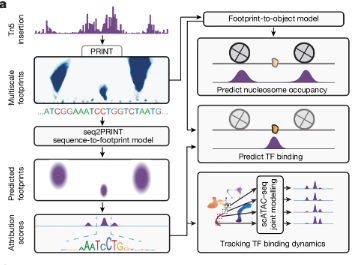

#### 背景

Seq2PRINT 是一个卷积神经网络（CNN），用于从 DNA 序列预测单碱基分辨率的多尺度 footprint，旨在揭示染色质开放性和转录因子（TF）结合模式。

#### 方法

- 数据输入：
	- 输入：长度 L 的 DNA 序列，one-hot 编码为 L × 4 矩阵。
	- 目标：多尺度 footprint（z 统计量）和 Tn5 插入数。
- 数据划分： 基于染色体的五折交叉验证，最终预测取平均。

#### 模型架构

- 结构：
	- 第一层：1024 个 21 bp 滤波器，GELU 激活。
	- 卷积块：8 层残差连接分组膨胀卷积（1024 个 3 bp 滤波器，膨胀率 2ⁱ，i=1-8），含批量归一化和前馈层，感受野 ±920 bp。
- 输出层：
	- 多尺度 footprint 层：1 bp 卷积。
	- 可及性层：全局平均池化 + 全连接，预测 Tn5 插入数。
- 任务： 回归预测 footprint 和 Tn5 插入数。

#### 训练与评估

- 训练： Keras 实现，Adam 优化器（学习率 3×10⁻⁴），MSE + 插入数损失，梯度仅由 footprint 驱动可及性层，批次高效 GPU 计算。
- 评估： 五折交叉验证，DeepLIFT 推导序列归因分数。

#### 应用

- 序列归因：
	- 方法：DeepLIFT，参考 20 个二核苷酸打乱序列。
	- 输出：
		1. Count 归因分数： 基于可及性层标量输出。
		2. Footprint 归因分数： 将 footprint 层 z 统计量转为 log(P 值)，对感兴趣区域或全峰求和。
- De novo 基序发现：
	- 工具：TF-MoDISco（100 万 seqlets），基于归因分数聚类新基序。
	- 匹配：TomTom 比对已知基序，finemo 定位 cCRE 内基序。
- TF 结合预测：
	- 输入：±100 bp 区域的 count 和 footprint 归因分数 + motif 匹配分数 + motif 与归因分数的 Pearson 相关性（405 维）。
	- 模型：三层神经网络（256-128-64，GELU 激活，0.25 dropout），Adam 优化，二分类交叉熵损失。
	- 结果：优于 footprint-to-TF 模型，用于图 2-4。
- LoRA 微调：
	- 目的：适配 scATAC-seq 数据多细胞状态。
	- 过程：预训练 seq2PRINT（全细胞聚合），对每个伪批量（pseudo-bulk）用 LoRA 微调。
	- 参数：低秩分解更新权重（A: de×r, B: r×dp），r=32，大幅减少参数量（n×dp → r(de+dp)）。
- 基序影响预测：
	- 方法：植入 de novo 或已知基序共识序列至 25,000 个 cCRE 中心，或打乱 motif 匹配位置，计算预测 footprint 差异。